In [8]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import joblib
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor


In [9]:
glucose = pd.read_csv('glucosedataset13.csv')
glucose.head()

,Age,BMI,Carbohydrate_Intake,Exercise_Level,Insulin_Dosage,BP,Sleep_Duration,Stress_Level,Glucose_Level
0,69,35.6,Medium,Sedentary,33.9,96,8.1,Medium,154.2
1,32,30.8,High,Sedentary,49.9,121,7.5,Medium,161.6
2,89,34.6,Low,Sedentary,1.5,76,5.0,Medium,163.4
3,78,30.0,Medium,Moderate,4.6,102,4.4,Medium,162.7
4,38,25.4,High,Sedentary,3.9,146,8.8,Low,178.9


In [10]:
glucose.info()
glucose.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  5000 non-null   int64  
 1   BMI                  5000 non-null   float64
 2   Carbohydrate_Intake  5000 non-null   object 
 3   Exercise_Level       5000 non-null   object 
 4   Insulin_Dosage       5000 non-null   float64
 5   BP                   5000 non-null   int64  
 6   Sleep_Duration       5000 non-null   float64
 7   Stress_Level         5000 non-null   object 
 8   Glucose_Level        5000 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 351.7+ KB


,Age,BMI,Insulin_Dosage,BP,Sleep_Duration,Glucose_Level
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,53.78360,27.308980,25.465560,119.233000,6.948260,140.335980
std,20.91777,7.151375,14.385512,15.092192,1.712754,26.179683
min,18.00000,15.000000,0.000000,67.000000,4.000000,55.100000
25%,36.00000,21.200000,13.275000,109.000000,5.500000,122.200000
50%,54.00000,27.200000,25.600000,119.000000,7.000000,140.400000
75%,72.00000,33.400000,37.700000,130.000000,8.400000,158.800000
max,90.00000,40.000000,50.000000,175.000000,10.000000,220.800000


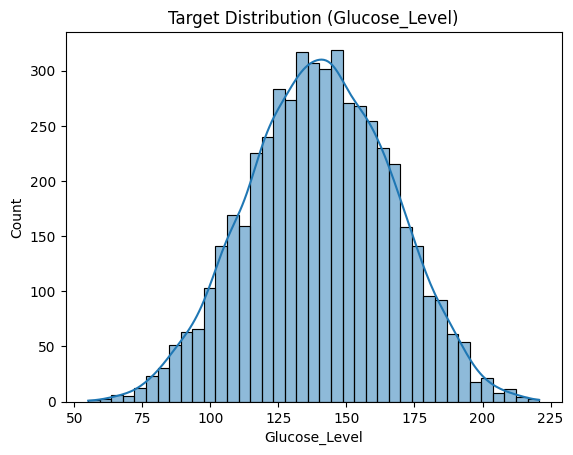

📈 Cross-Validation R² scores: [0.94900878 0.95333829 0.95194516 0.9577794  0.95475876]
Mean CV R²: 0.95

📊 Test Set Evaluation:
MAE:  4.09
RMSE: 5.37
R²:   0.95


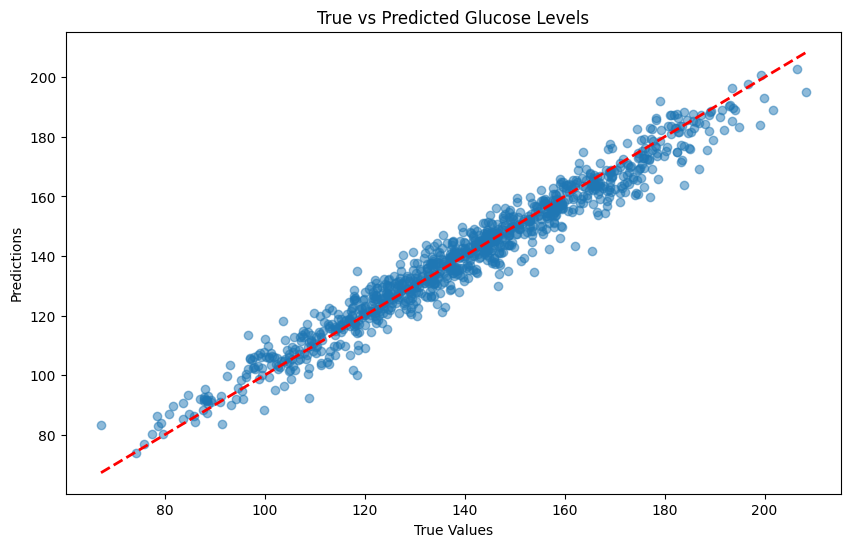

In [11]:
sns.histplot(glucose['Glucose_Level'], kde=True)
plt.title('Target Distribution (Glucose_Level)')
plt.show()

X = glucose.drop('Glucose_Level', axis=1)
y = glucose['Glucose_Level']

categorical_cols = ['Carbohydrate_Intake', 'Exercise_Level', 'Stress_Level']
numerical_cols = ['Age', 'BMI', 'Insulin_Dosage', 'BP', 'Sleep_Duration']

ordinal_encoder = OrdinalEncoder(categories=[
    ['Low', 'Medium', 'High'],         
    ['Sedentary', 'Moderate', 'Active'],  
    ['Low', 'Medium', 'High']          
])

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', ordinal_encoder, categorical_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print(f"📈 Cross-Validation R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.2f}")

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 Test Set Evaluation:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.title('True vs Predicted Glucose Levels')
plt.show()




In [12]:
model_table = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'R2', 'CV_R2'])

models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'Linear Regression': LinearRegression()
}


for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),  
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    cv_r2 = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2').mean()
    
    model_table = pd.concat([model_table, pd.DataFrame([{
        'Model': name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R2': round(r2, 2),
        'CV_R2': round(cv_r2, 2)
    }])], ignore_index=True)
model_table.sort_values(by='R2', ascending=False, inplace=True)
model_table.reset_index(drop=True, inplace=True)


print(model_table)

model_table.to_csv('best_models_summary.csv', index=False)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 8
[LightGBM] [Info] Start training from score 140.406325
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 8
[LightGBM] [Info] Start training from score 140.461594
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 8
[LightGBM] [Info] Start training

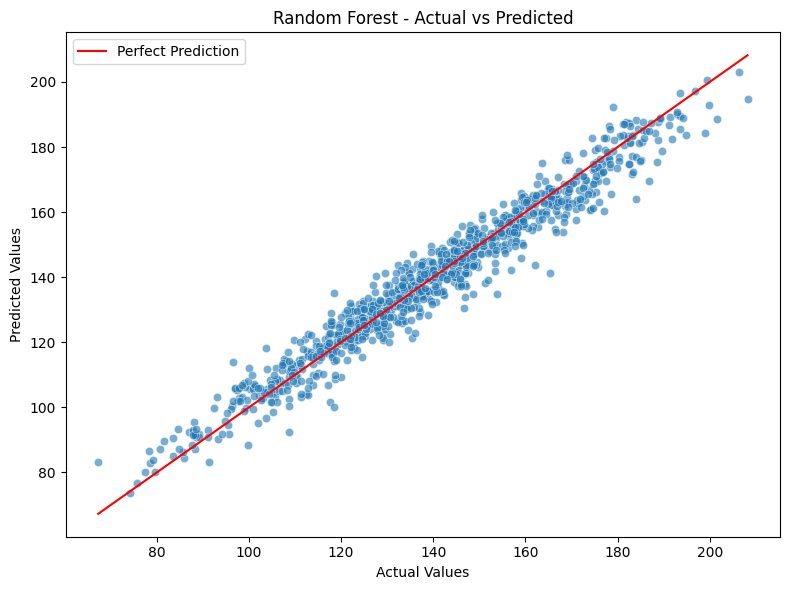

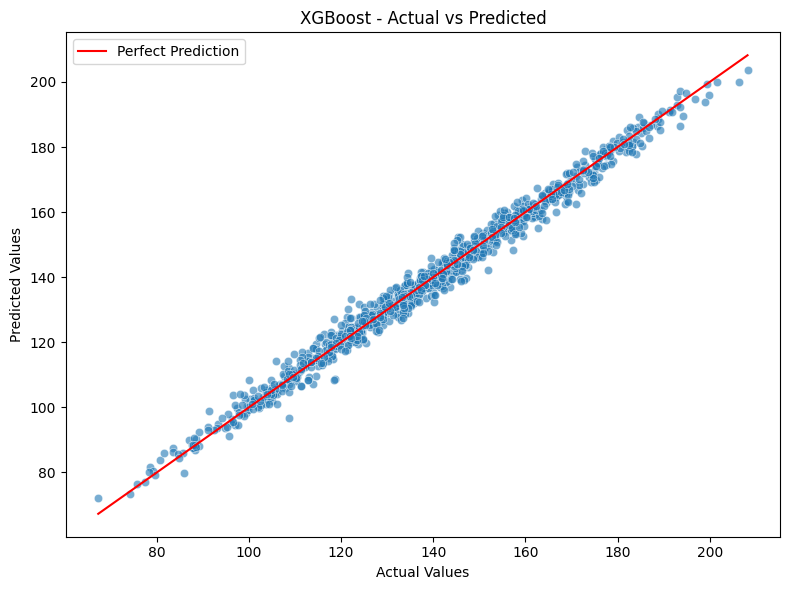

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 8
[LightGBM] [Info] Start training from score 140.406325


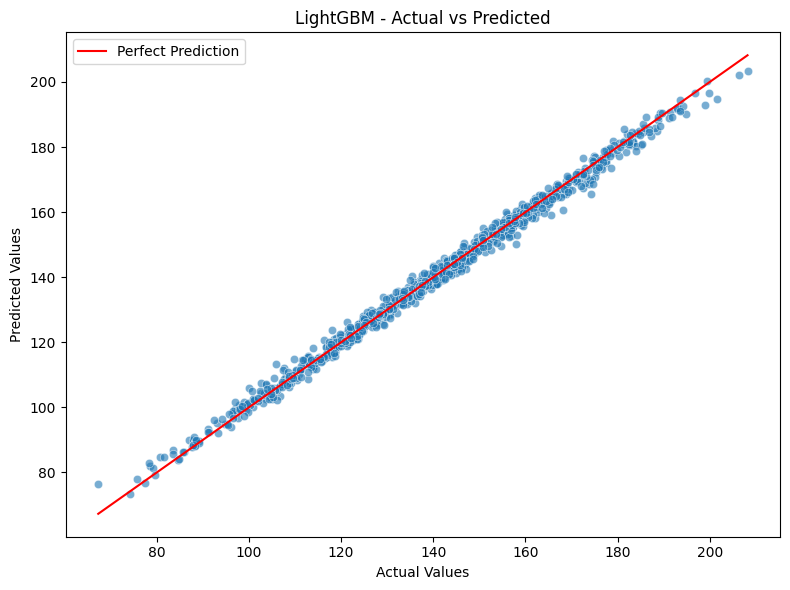

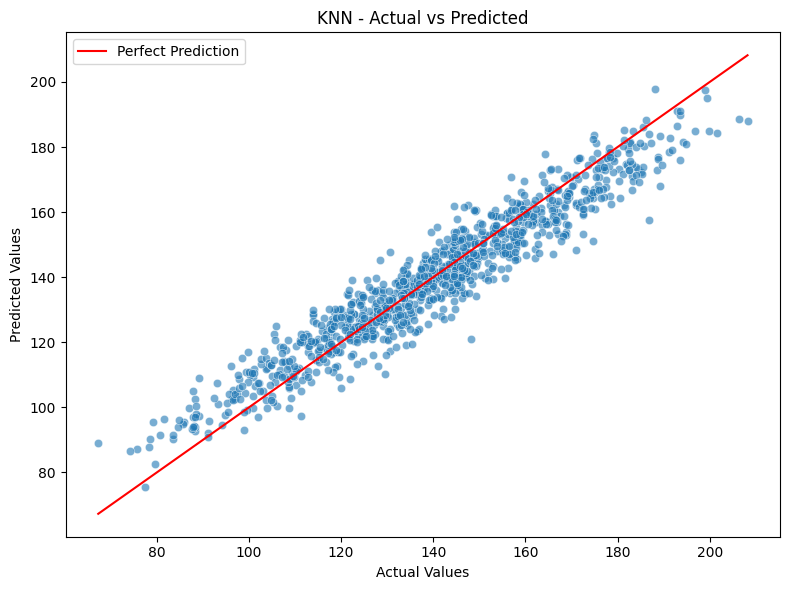

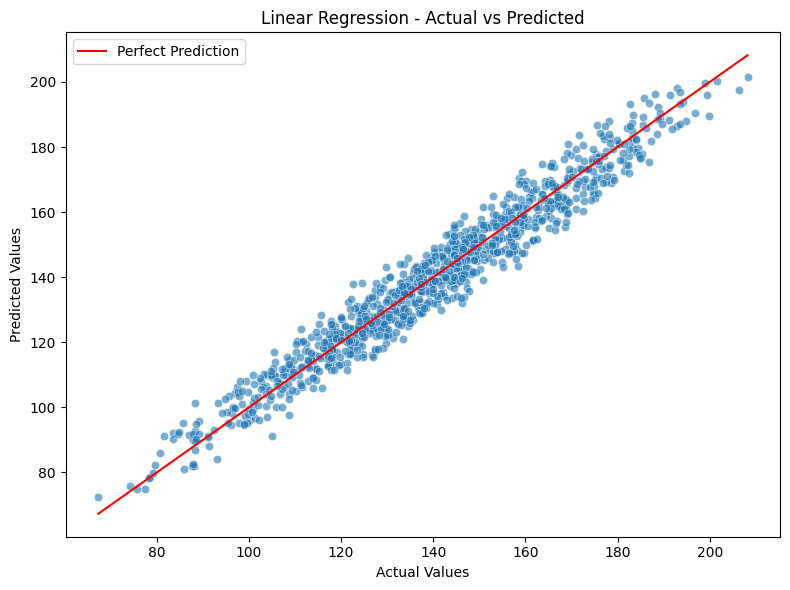

In [13]:
plot_dir = 'model_predictions'
os.makedirs(plot_dir, exist_ok=True)

models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'Linear Regression': LinearRegression()
}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)

    predictions = pipeline.predict(X_test)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
    sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{name} - Actual vs Predicted')
    plt.legend()
    plt.tight_layout()

    plt.show()

    file_path = os.path.join(plot_dir, f'{name.replace(" ", "_").lower()}_actual_vs_predicted.png')
    plt.savefig(file_path)

    plt.close()


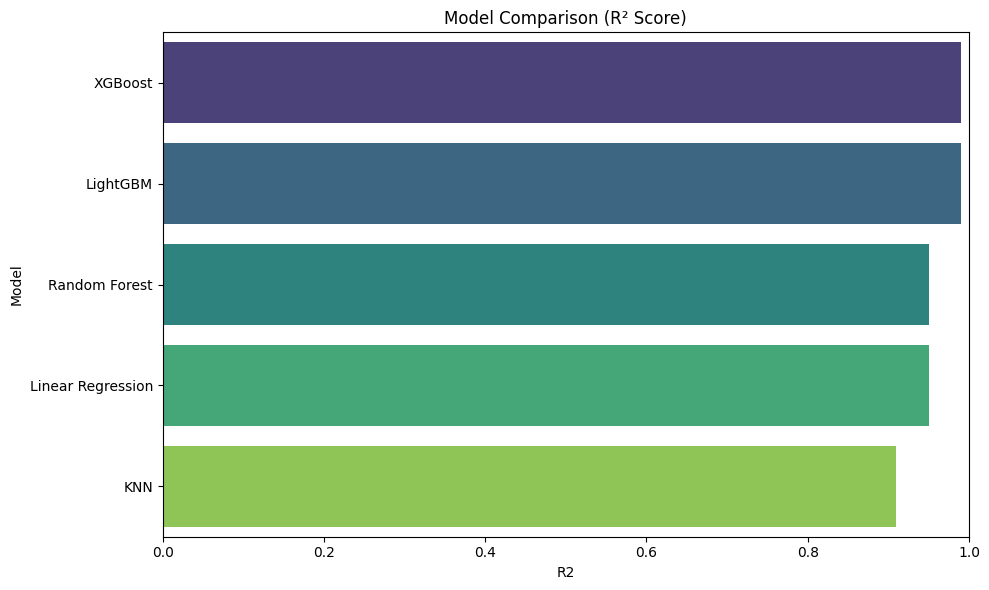

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x='R2', y='Model', data=model_table.sort_values(by='R2', ascending=False), palette='viridis')
plt.title('Model Comparison (R² Score)')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


In [15]:
import joblib

top_models_df = model_table.sort_values(by='R2', ascending=False).head(3)

saved_models = {}
for model_name in top_models_df['Model']:
    model = models[model_name]  
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    file_path = f"best_model_{model_name.replace(' ', '_').lower()}.pkl"
    joblib.dump(pipeline, file_path)
    saved_models[model_name] = file_path
    print(f"✅ Saved: {model_name} → {file_path}")


✅ Saved: XGBoost → best_model_xgboost.pkl
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 8
[LightGBM] [Info] Start training from score 140.406325
✅ Saved: LightGBM → best_model_lightgbm.pkl
✅ Saved: Random Forest → best_model_random_forest.pkl
